In [1]:
import time
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
#from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
from transformers import data
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
from datetime import timedelta

2022-11-10 14:37:04.019896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/data/home/anagara8/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/nvidia-390
2022-11-10 14:37:04.019942: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# VAE Model
#1C_VAE_SmoothOneBeta
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=256):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        initial_conv1 = self.ResNet18.conv1
        self.ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # Convert 3C to 1C
        self.ResNet18.conv1.weight = nn.Parameter(torch.unsqueeze(initial_conv1.weight[:, 0, :, :], 1))
        self.ResNet18.fc = nn.Linear(self.num_feature, 2*self.z_dim)
        
        # Initialise normalized weights
#         torch.nn.init.kaiming_normal_(self.ResNet18.fc.weight)
            
        # BatchNorm
#         self.relu = nn.ReLU(inplace=True)
#         self.fc_bn = nn.BatchNorm1d(2*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
#         x = self.relu(x)
#         x = self.fc_bn(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=1):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)
#         self.fc = nn.Linear(nc, nc)
#         self.bn = nn.BatchNorm1d(nc)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
#         x = self.bn(x)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=2)
        x = self.layer4(x)
        x = F.interpolate(x, scale_factor=2)
        x = self.layer3(x)
        x = F.interpolate(x, scale_factor=2)
        x = self.layer2(x)
        x = F.interpolate(x, scale_factor=2)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 1, 224, 224)
        return x
    
class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        r = self.decoder(z)
        return r, mu, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
#         return epsilon.mul(std).add_(mean)
        return epsilon * std + mean

In [5]:
zsize = 1024
vae = VAE(zsize)
# for n,p in vae.named_parameters():
#     print(n, p.grad)
# vae = nn.DataParallel(vae)
vae

VAE(
  (encoder): ResNet18Enc(
    (ResNet18): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNor

In [30]:
print("Traversing Image Directory..")
img_list = np.load("/media/data_cifs/anagara8/smoothed_tracking_img_list.npy") # os.listdir(data_dir)
random.shuffle(img_list)
print("Done!")

Traversing Image Directory..
Done!


In [31]:
img_list = img_list[:320]
m=len(img_list)

print("Length:",m, "-> Training set size:", int(math.ceil(m-m*0.2)), "| Validation set size:", int(m*0.2))
train_data, val_data = random_split(img_list, [int(math.ceil(m-m*0.2)), int(m*0.2)])

Length: 320 -> Training set size: 256 | Validation set size: 64


In [32]:
mean = [0.485]  # Resnet
std = [0.229]

transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])

In [33]:
class NIH_Cropped_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_list, augmentations = None):
        super(NIH_Cropped_Dataset, self).__init__()
        self.img_list = img_list
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img = cv2.imread("/media/data_cifs/anagara8/final_smooth_video_processed_frames/"+img_name)
        img = img[:, :, 0]
        
        img = torch.tensor(img).float()/255.0
        img = torch.unsqueeze(img, 0)
#         img = transform_norm(img)
        
        # img = torch.permute(img, (2, 0, 1))#         
        
        return img

In [34]:
batch_size=32
train_set_loader = torch.utils.data.DataLoader(NIH_Cropped_Dataset(train_data), batch_size=batch_size, num_workers = 4, shuffle=True)
valid_set_loader = torch.utils.data.DataLoader(NIH_Cropped_Dataset(val_data), batch_size=batch_size, num_workers = 4, shuffle=True)
print("Converted to DataLoader")

Converted to DataLoader


In [63]:
# custom_beta = 1e-5
def loss_functionVAE(recon_x, x, mu, logvar):
#     KLD = -0.5 * torch.sum(1+logvar - mu.pow(2) - logvar.exp())
#     KLD = -0.5 * torch.sum(mu ** 2 + logvar ** 2 - torch.log(1e-8 + logvar ** 2) - 1) / np.prod(x.shape)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=1),dim=0)
    MSE = nn.MSELoss()(recon_x, x)
    beta = 1e-8
#     while beta*KLD > MSE:
#         beta /= 10
# #     beta = custom_beta
    return MSE + beta*KLD, MSE, beta*KLD, KLD

In [36]:
zsize = 1024
vae = VAE(zsize)
# for n,p in vae.named_parameters():
#     print(n, p.grad)
vae = nn.DataParallel(vae)
vae = vae.cuda()

In [64]:
number_of_epochs = 100
learningRate= 0.00005

autoencoder_optimizer = optim.Adam(vae.parameters(), lr = learningRate)
scheduler = optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=30, gamma = 0.1)

In [38]:
# Gradient Flow
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
#         p = p.detach().cpu()
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().numpy())
#     plt.figure(figsize=(15, 15))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
#     plt.ylim(ymin=0, ymax=5)
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [39]:
list_train_loss = []
list_val_loss = []
list_train_MSE = []
list_val_MSE = []
list_train_KLD = []
list_val_KLD = []

[1] Loss -> Training: 0.0000148 | Validation: 0.0001204 in 3.23 seconds. (real KLD:467.0609, MSE: 0.0000)
[2] Loss -> Training: 0.0000154 | Validation: 0.0001186 in 2.93 seconds. (real KLD:499.0121, MSE: 0.0000)
[3] Loss -> Training: 0.0000144 | Validation: 0.0001202 in 3.09 seconds. (real KLD:509.4875, MSE: 0.0001)
[4] Loss -> Training: 0.0000129 | Validation: 0.0001167 in 3.15 seconds. (real KLD:515.6829, MSE: 0.0001)
[5] Loss -> Training: 0.0000122 | Validation: 0.0001184 in 3.26 seconds. (real KLD:517.1085, MSE: 0.0001)
[6] Loss -> Training: 0.0000117 | Validation: 0.0001180 in 3.26 seconds. (real KLD:560.5054, MSE: 0.0001)
[7] Loss -> Training: 0.0000121 | Validation: 0.0001178 in 3.39 seconds. (real KLD:570.0365, MSE: 0.0001)
[8] Loss -> Training: 0.0000116 | Validation: 0.0001193 in 3.31 seconds. (real KLD:564.8722, MSE: 0.0001)
[9] Loss -> Training: 0.0000115 | Validation: 0.0001173 in 3.06 seconds. (real KLD:592.9556, MSE: 0.0000)
[10] Loss -> Training: 0.0000116 | Validation:

[78] Loss -> Training: 0.0000100 | Validation: 0.0001189 in 3.31 seconds. (real KLD:905.1646, MSE: 0.0000)
[79] Loss -> Training: 0.0000100 | Validation: 0.0001181 in 2.84 seconds. (real KLD:894.3370, MSE: 0.0001)
[80] Loss -> Training: 0.0000098 | Validation: 0.0001191 in 3.24 seconds. (real KLD:913.3016, MSE: 0.0001)
[81] Loss -> Training: 0.0000102 | Validation: 0.0001209 in 3.23 seconds. (real KLD:922.3287, MSE: 0.0001)
[82] Loss -> Training: 0.0000100 | Validation: 0.0001198 in 3.11 seconds. (real KLD:920.8972, MSE: 0.0001)
[83] Loss -> Training: 0.0000104 | Validation: 0.0001206 in 3.40 seconds. (real KLD:921.3797, MSE: 0.0001)
[84] Loss -> Training: 0.0000099 | Validation: 0.0001196 in 2.92 seconds. (real KLD:946.9318, MSE: 0.0001)
[85] Loss -> Training: 0.0000102 | Validation: 0.0001172 in 3.46 seconds. (real KLD:955.7338, MSE: 0.0001)
[86] Loss -> Training: 0.0000102 | Validation: 0.0001192 in 4.30 seconds. (real KLD:916.5925, MSE: 0.0001)
[87] Loss -> Training: 0.0000097 | Va

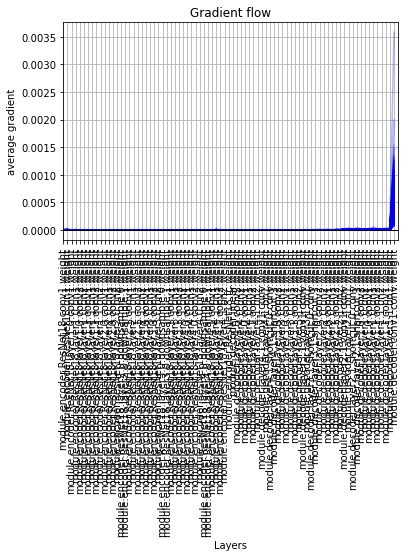

In [65]:
for epoch in range(number_of_epochs):
    start_time = time.time()

    train_run_loss = 0 
    train_run_KLD = 0 
    train_run_MSE = 0 

    val_run_loss = 0
    val_run_KLD = 0
    val_run_MSE = 0

    vae.train(True) # For training
    for image_batch1 in train_set_loader:
        image_batch1 = image_batch1.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img, mu, logvar = vae(image_batch1)
        original_train_loss, train_MSE, train_KLD, _ = loss_functionVAE(enc_dec_img, image_batch1, mu, logvar)
        train_loss, train_MSE, train_KLD = original_train_loss.data.item()/int(math.ceil(m-m*0.2)), train_MSE.data.item()/int(math.ceil(m-m*0.2)), train_KLD.data.item()/int(math.ceil(m-m*0.2))
        # Backward pass
        original_train_loss.backward()
        plot_grad_flow(vae.named_parameters())
        autoencoder_optimizer.step()
        train_run_loss += train_loss
        train_run_MSE += train_MSE
        train_run_KLD += train_KLD

    vae.eval()
    for image_batch2 in valid_set_loader:
        image_batch2 = image_batch2.cuda()
        autoencoder_optimizer.zero_grad()
        enc_dec_img2, mu, logvar = vae(image_batch2)
        original_val_loss, val_MSE, val_KLD, kld = loss_functionVAE(enc_dec_img2, image_batch2, mu, logvar)
        val_loss, val_MSE, val_KLD = original_val_loss.data.item()/int(m*0.2), val_MSE.data.item()/int(m*0.2), val_KLD.data.item()/int(m*0.2)
        val_run_loss += val_loss
        val_run_MSE += val_MSE
        val_run_KLD += val_KLD
        
    print('[%d] Loss -> Training: %.7f | Validation: %.7f in %.2f seconds. (real KLD:%.4f, MSE: %.4f)' % (epoch + 1, train_run_loss, val_run_loss, time.time() - start_time, kld, val_MSE))
    list_val_loss.append(val_run_loss)
    list_train_loss.append(train_run_loss)
    list_val_MSE.append(val_run_MSE)
    list_train_MSE.append(train_run_MSE)
    list_val_KLD.append(val_run_KLD)
    list_train_KLD.append(train_run_KLD)

#     plt.plot(range(epoch+1),list_train_loss,'tab:orange',label='Training Loss')
#     plt.plot(range(epoch+1),list_val_loss,'tab:blue',label='Validation Loss')
#     plt.plot(range(epoch+1),list_train_MSE,'tab:orange',label='Training Loss MSE')
#     plt.plot(range(epoch+1),list_val_MSE,'tab:blue',label='Validation Loss MSE')
#     plt.plot(range(epoch+1),list_train_KLD,'tab:orange',label='Training Loss KLD')
#     plt.plot(range(epoch+1),list_val_KLD,'tab:blue',label='Validation Loss KLD')

#     if epoch%10 == 0:
#         plt.figure()
#         plt.imshow(torch.permute(image_batch2[0], (1, 2, 0)).detach().cpu().numpy(), cmap='gray')
#         plt.figure()
#         plt.imshow(torch.permute(enc_dec_img2[0], (1, 2, 0)).detach().cpu().numpy(), cmap='gray')
#         torch.save(vae.state_dict(), "1C_VAE_SmoothHalfBeta_4096z_e"+str(epoch)+"_vL"+str(val_run_loss)+".p")
#     if epoch==0:
#         plt.legend(loc='upper left')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
        
    val_run_loss = 0.0
    train_run_loss = 0.0
    
print('Finished Training')

In [15]:
!ls -ltr DebugVAE*

-rw-r--r-- 1 anagara8 user-anagara8 96587029 Oct  2 23:27 DebugVAE_e1500_onlyMSE.p
-rw-r--r-- 1 anagara8 user-anagara8   141261 Oct  7 01:27 DebugVAE.ipynb


In [16]:
# torch.save(vae.state_dict(), "./DebugVAE_e1500_onlyMSE.p")
# vae = torch.load(vae.state_dict(), "./DebugVAE_e1500_onlyMSE.p")

## View Reconstructions

In [54]:
def plot_vae_outputs(vae, n=10):
    plt.figure(figsize=(32,9))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        
        img = train_set_loader.dataset[i].unsqueeze(0).cuda()
        vae.eval()
        with torch.no_grad():
            enc_dec_img, mean, logvar  = vae(img)
#             print("Image:", img[0])
#             print("Mean:", mean)
#             print("Logvar:", logvar)
#             print("Reconstruction:", enc_dec_img)
        temp = torch.permute(img[0].cpu(), (1, 2, 0))
        
        rec_img = torch.squeeze(torch.permute(enc_dec_img[0], (1, 2, 0))).cpu()
        plt.imshow(temp, cmap='gist_gray')
        if i == n//2:
            ax.set_title('Original images')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

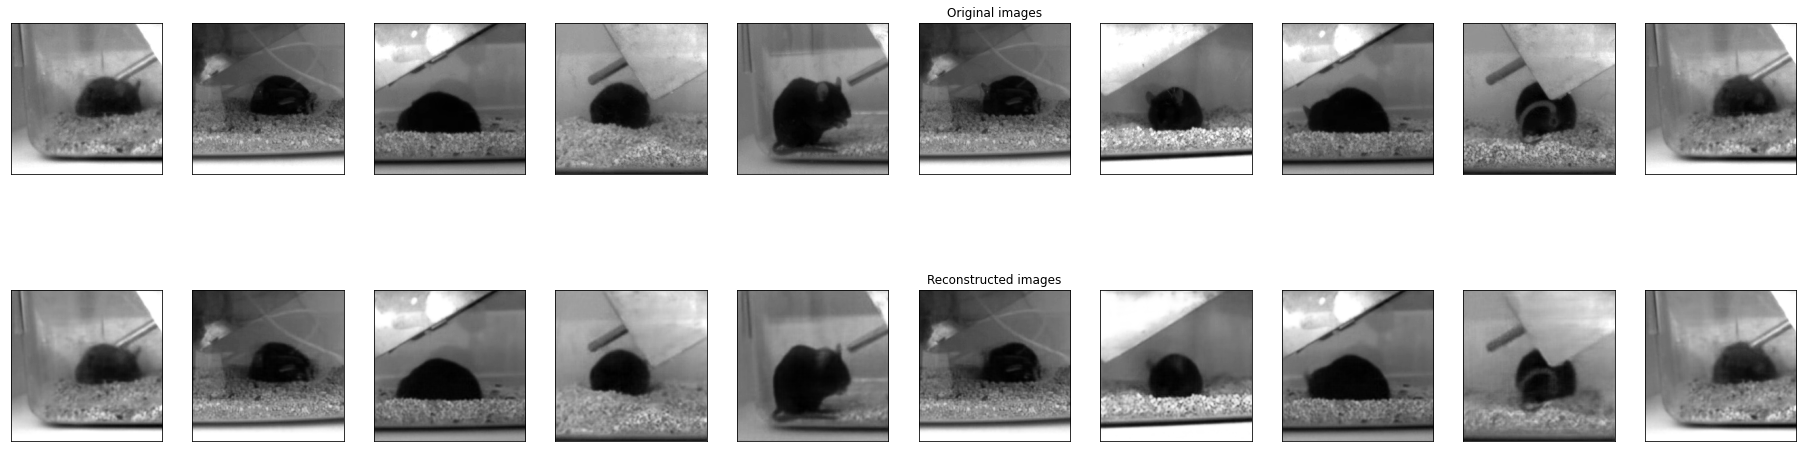

In [66]:
plot_vae_outputs(vae)

In [67]:
datapoints = pd.read_hdf("/media/data_cifs/anagara8/FC-D_6394846-Akash-2022-10-19/videos/video_2019Y_05M_31D_05h_51m_44s_cam_6394846-0000DLC_resnet50_FC-D_6394846Oct19shuffle1_250000.h5")

In [68]:
datapoints.iloc[0]

scorer                                         bodyparts  coords    
DLC_resnet50_FC-D_6394846Oct19shuffle1_250000  Nose       x             416.679871
                                                          y             390.210846
                                                          likelihood      0.999601
                                               InnerEar   x             398.361053
                                                          y             363.548157
                                                          likelihood      0.999761
                                               Spine1     x             397.203461
                                                          y             343.988556
                                                          likelihood      0.999180
                                               Spine2     x             424.778595
                                                          y             342.260681
                  

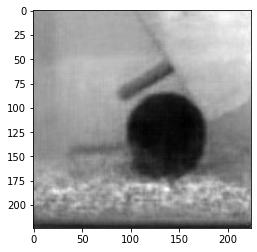

In [19]:
# Unnormalizing
unnorm_mean = [-(0.485/0.229)]  # Resnet
unnorm_std = [(1/0.229)]

transform_unnorm = transforms.Compose([
    transforms.Normalize(unnorm_mean, unnorm_std)
])

t = train_set_loader.dataset[0].unsqueeze(0).cuda()
r, _, _ = vae(t)
r = transform_unnorm(r[0])
r = torch.squeeze(torch.permute(r, (1, 2, 0))).detach().cpu().numpy()
plt.imshow(r, cmap='gray')

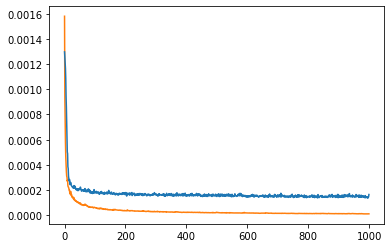

In [20]:
plt.plot(range(epoch+1),list_train_loss,'tab:orange',label='Training Loss')
plt.plot(range(epoch+1),list_val_loss,'tab:blue',label='Validation Loss')

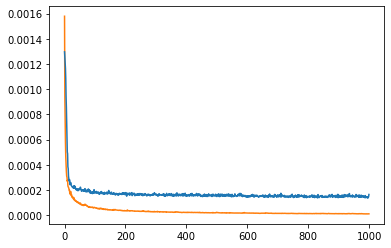

In [21]:
plt.plot(range(epoch+1),list_train_MSE,'tab:orange',label='Training Loss MSE')
plt.plot(range(epoch+1),list_val_MSE,'tab:blue',label='Validation Loss MSE')

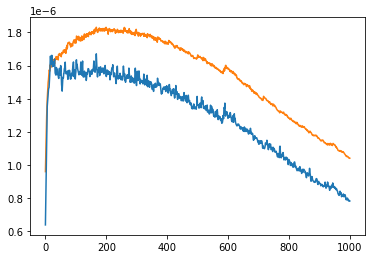

In [22]:
plt.plot(range(epoch+1),list_train_KLD,'tab:orange',label='Training Loss KLD')
plt.plot(range(epoch+1),list_val_KLD,'tab:blue',label='Validation Loss KLD')

In [23]:
plots = {"epochs": number_of_epochs,
         "total_train": list_train_loss,
         "total_val": list_val_loss,
         "MSE_train": list_train_MSE,
         "MSE_val": list_val_MSE,
         "KLD_train": list_train_KLD,
         "KLD_val": list_val_KLD}
print("Plotes saved: PLOTSz"+str(zsize)+"_beta"+str(custom_beta)+".npy")
np.save("PLOTSNoNorm_z"+str(zsize)+"_beta"+str(custom_beta)+".npy", plots)

Plotes saved: PLOTSz1024_beta1e-05.npy


In [69]:
a = np.load("catsanddogs.npy", allow_pickle=True)

In [71]:
import tensorflow as tf
import keras

In [97]:
new_data = {}

In [100]:
animals = []
for data in a[None][0]["dogs"]:
    animals.append(data)
#     labels.append(0)

In [101]:
new_data["dogs"] = animals

In [105]:
len(new_data["dogs"])

10

In [106]:
np.save("catsanddogs.npy", new_data)

In [107]:
a = np.load("catsanddogs.npy", allow_pickle=True)

In [113]:
a.item()

{'cats': [array([0.87878788, 0.36363636, 0.60606061, 0.39393939, 0.39393939,
         0.54545455, 0.3030303 , 0.6969697 , 0.48484848, 0.48484848,
         0.57575758, 0.57575758, 0.75757576, 0.48484848, 0.51515152,
         0.54545455, 0.6969697 , 0.60606061]),
  array([1.     , 0.40625, 0.625  , 0.53125, 0.4375 , 0.6875 , 0.375  ,
         0.75   , 0.53125, 0.46875, 0.84375, 0.65625, 0.9375 , 0.625  ,
         0.84375, 0.65625, 0.6875 , 0.6875 ]),
  array([0.63636364, 0.36363636, 0.36363636, 0.36363636, 0.36363636,
         0.27272727, 0.27272727, 0.45454545, 0.36363636, 0.27272727,
         0.45454545, 0.36363636, 0.54545455, 0.27272727, 0.45454545,
         0.36363636, 0.45454545, 0.45454545]),
  array([0.75675676, 0.32432432, 0.45945946, 0.45945946, 0.37837838,
         0.45945946, 0.18918919, 0.7027027 , 0.40540541, 0.32432432,
         0.54054054, 0.32432432, 0.81081081, 0.43243243, 0.59459459,
         0.54054054, 0.64864865, 0.62162162]),
  array([0.6 , 0.25, 0.3 , 0.25, 0.2 , 

In [75]:
# animals = []
# labels = []

for data in a[None][0]["cats"]:
    animals.append(data)
    labels.append(0)

In [90]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [91]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
len(labels)

20

In [93]:
from tensorflow.keras import utils
l = utils.to_categorical(labels)

In [95]:
history = model.fit(np.array(animals), np.array(l), epochs=1000, validation_split=0.3)

Epoch 1/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.6579 - val_accuracy: 0.8333
Epoch 2/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.6598 - val_accuracy: 0.8333
Epoch 3/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.6625 - val_accuracy: 0.8333
Epoch 4/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.6657 - val_accuracy: 0.8333
Epoch 5/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.6695 - val_accuracy: 0.8333
Epoch 6/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.6738 - val_accuracy: 0.8333
Epoch 7/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.6782 - val_accuracy: 0.8333
Epoch 8/1000


Epoch 59/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.7504 - val_accuracy: 0.8333
Epoch 60/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.7507 - val_accuracy: 0.8333
Epoch 61/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.7510 - val_accuracy: 0.8333
Epoch 62/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.7514 - val_accuracy: 0.8333
Epoch 63/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.7518 - val_accuracy: 0.8333
Epoch 64/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.7522 - val_accuracy: 0.8333
Epoch 65/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.7527 - val_accuracy: 0.8333
Epoch 

1/1 [==============================] - 0s 23ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.7842 - val_accuracy: 0.8333
Epoch 174/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.7844 - val_accuracy: 0.8333
Epoch 175/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.7847 - val_accuracy: 0.8333
Epoch 176/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.7850 - val_accuracy: 0.8333
Epoch 177/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.7852 - val_accuracy: 0.8333
Epoch 178/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.7855 - val_accuracy: 0.8333
Epoch 179/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.7857 - val_accuracy: 0.8333
Epoch 180/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.8103 - val_accuracy: 0.8333
Epoch 288/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.8105 - val_accuracy: 0.8333
Epoch 289/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.8107 - val_accuracy: 0.8333
Epoch 290/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.8109 - val_accuracy: 0.8333
Epoch 291/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.8111 - val_accuracy: 0.8333
Epoch 292/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.8113 - val_accuracy: 0.8333
Epoch 293/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.8115 - val_accuracy: 0.8333
Epoch 294/1000

1/1 [==============================] - 0s 25ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.8330 - val_accuracy: 0.8333
Epoch 402/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.8332 - val_accuracy: 0.8333
Epoch 403/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.8334 - val_accuracy: 0.8333
Epoch 404/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.8336 - val_accuracy: 0.8333
Epoch 405/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.8337 - val_accuracy: 0.8333
Epoch 406/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.8339 - val_accuracy: 0.8333
Epoch 407/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.8341 - val_accuracy: 0.8333
Epoch 408/1000

1/1 [==============================] - 0s 27ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8532 - val_accuracy: 0.8333
Epoch 516/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8534 - val_accuracy: 0.8333
Epoch 517/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8535 - val_accuracy: 0.8333
Epoch 518/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8537 - val_accuracy: 0.8333
Epoch 519/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8539 - val_accuracy: 0.8333
Epoch 520/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8541 - val_accuracy: 0.8333
Epoch 521/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.8544 - val_accuracy: 0.8333
Epoch 522/1000

1/1 [==============================] - 0s 23ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8717 - val_accuracy: 0.8333
Epoch 630/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8718 - val_accuracy: 0.8333
Epoch 631/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8719 - val_accuracy: 0.8333
Epoch 632/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8721 - val_accuracy: 0.8333
Epoch 633/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8722 - val_accuracy: 0.8333
Epoch 634/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8724 - val_accuracy: 0.8333
Epoch 635/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.8726 - val_accuracy: 0.8333
Epoch 636/1000

1/1 [==============================] - 0s 36ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8884 - val_accuracy: 0.8333
Epoch 744/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8886 - val_accuracy: 0.8333
Epoch 745/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8887 - val_accuracy: 0.8333
Epoch 746/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8889 - val_accuracy: 0.8333
Epoch 747/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8891 - val_accuracy: 0.8333
Epoch 748/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8893 - val_accuracy: 0.8333
Epoch 749/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8894 - val_accuracy: 0.8333
Epoch 750/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9047 - val_accuracy: 0.8333
Epoch 858/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9048 - val_accuracy: 0.8333
Epoch 859/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9050 - val_accuracy: 0.8333
Epoch 860/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9052 - val_accuracy: 0.8333
Epoch 861/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9053 - val_accuracy: 0.8333
Epoch 862/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9055 - val_accuracy: 0.8333
Epoch 863/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.9057 - val_accuracy: 0.8333
Epoch 864/1000

1/1 [==============================] - 0s 40ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9200 - val_accuracy: 0.8333
Epoch 972/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9201 - val_accuracy: 0.8333
Epoch 973/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9202 - val_accuracy: 0.8333
Epoch 974/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9203 - val_accuracy: 0.8333
Epoch 975/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9205 - val_accuracy: 0.8333
Epoch 976/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9206 - val_accuracy: 0.8333
Epoch 977/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9207 - val_accuracy: 0.8333
Epoch 978/1000

In [4]:
pf6 = cv2.imread("/media/data_cifs/projects/prj_LRA/PathFinder/pathfinder128/curv_contour_length_6/imgs/1/sample_0.png")
pf14 = cv2.imread("/media/data_cifs/projects/prj_LRA/PathFinder/pathfinder128/curv_contour_length_14/imgs/1/sample_0.png")
pf22 = cv2.imread("/media/data_cifs/projects/prj_LRA/PathFinder/pathfinder128/curv_contour_length_22/imgs/1/sample_0.png")


NameError: name 'self' is not defined

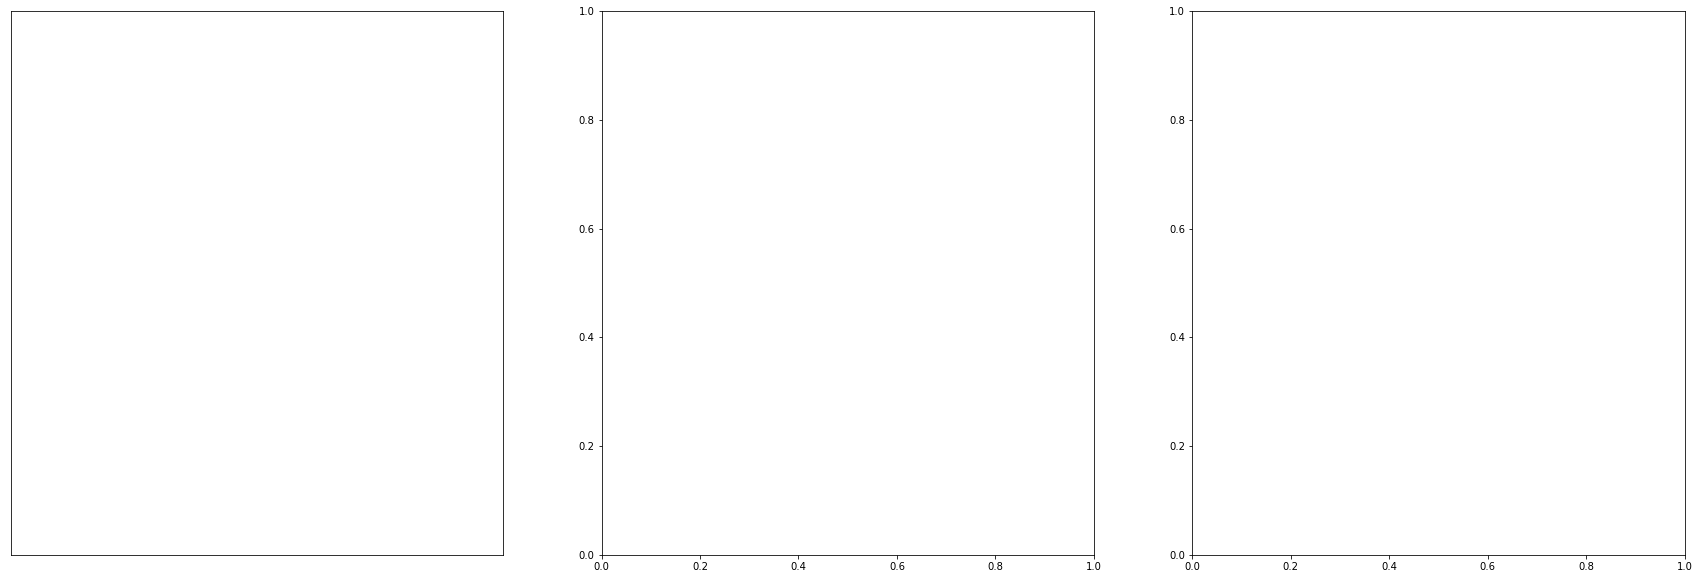

In [18]:
fig, ax = plt.subplots(1,3, figsize=(30, 10))
for i in range(3):
    ax[i].axes.get_xaxis().set_ticks([])
    ax[i].axes.get_yaxis().set_ticks([])
    ax[i].set_title(self, label, fontdict=None, loc='center', pad=None, **kwargs)
#     ax[i].axes.set_title("Hi")
ax[0].imshow(pf6)
ax[1].imshow(pf14)
ax[2].imshow(pf22)